# Data Preprocessing

We will use all  the csv files generated during our last step (Data Collection) into a single data frame and also dump it to the disk for future reference

In [15]:
# merge PlayStationWrapUp2024.csv and playstationwrapus.csv
import pandas as pd
def change_hashtag(filepath, hashtag):
    df = pd.read_csv(filepath)
    df['hashtag'] = hashtag
    df.to_csv(filepath, index=False)

change_hashtag('./data/2_#PlayStationWrapUp2024.csv', '#playstationwrapup')

change_hashtag('./data/12_#ThursdayThoughts.csv', '#thursdaythoughts')
change_hashtag('./data/7_#thursdayvibes.csv', '#thursdaythoughts')
change_hashtag('./data/4_#ThursdayMotivation.csv', '#thursdaythoughts')


In [16]:
# lets combine all the csv files into one
import glob
import pandas as pd
import os

# delete the all_tweets.csv file if it exists
if os.path.exists('./data/all_tweets.csv'):
    os.remove('./data/all_tweets.csv')

# get data file names
data_files = glob.glob('./data/*.csv')
data = pd.concat([pd.read_csv(file) for file in data_files], ignore_index=True)

# filter out tweets that are not in English
data = data[data['lang'] == 'en']

# remove duplicates
data = data.drop_duplicates(subset='text')

# remove rows with #thursdaythoughts hashtag
data = data[~data['hashtag'].str.contains('#thursdaythoughts', case=False)]

# reindex the dataframe
data.reset_index(drop=True, inplace=True)
data.drop(columns=['lang'], inplace=True)

data.to_csv('./data/all_tweets.csv', index=False)

data

,text,all_hashtags,hashtag,cleaned_text,processed_text,tweet_tokenizer_processed_text,word2vec_embedding,bert_embedding
0,When you've been working 2 jobs all year and s...,['PlayStationWrapUp2024'],#playstationwrapup,NaN,NaN,NaN,NaN,NaN
1,my #PlayStationWrapUp2024 😎\n\nshare yours in ...,['PlayStationWrapUp2024'],#playstationwrapup,NaN,NaN,NaN,NaN,NaN
2,#PlayStationWrapUp2024 101 Games this year and...,['PlayStationWrapUp2024'],#playstationwrapup,NaN,NaN,NaN,NaN,NaN
3,I'm shocked! 😏😂\n\n#PlayStationWrapUp2024 http...,['PlayStationWrapUp2024'],#playstationwrapup,NaN,NaN,NaN,NaN,NaN
4,My #PlayStationWrapUp2024 has some incorrect n...,['PlayStationWrapUp2024'],#playstationwrapup,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
460,@PatMcAfeeShow @TheOregonDuck Cashapp $Haz...,['PMSLive'],#PMSLive,NaN,NaN,NaN,NaN,NaN
461,Hello beautiful people..\n\nIT IS AARON RODGER...,['PMSLive'],#PMSLive,NaN,NaN,NaN,NaN,NaN
462,"""FLY EAGLES FLY"" ~ @aqshipley #PMSLive https:/...",['PMSLive'],#PMSLive,NaN,NaN,NaN,NaN,NaN
463,WHAT A CATCH BY @TheOregonDuck 😂😂\n\n#PMSLive ...,['PMSLive'],#PMSLive,NaN,NaN,NaN,NaN,NaN


In [17]:
data.describe(include='all')

,text,all_hashtags,hashtag,cleaned_text,processed_text,tweet_tokenizer_processed_text,word2vec_embedding,bert_embedding
count,465,465,465,0,0,0,0,0
unique,465,129,13,0,0,0,0,0
top,When you've been working 2 jobs all year and s...,['RHOSLC'],#BBMAs,NaN,NaN,NaN,NaN,NaN
freq,1,38,43,NaN,NaN,NaN,NaN,NaN


The dataset contains the following key columns:

1. **`text`**: The content of the tweets.
2. **`all_hashtags`**: A list of all hashtags present in the tweet.
3. **`hashtag`**: The primary trending hashtag.

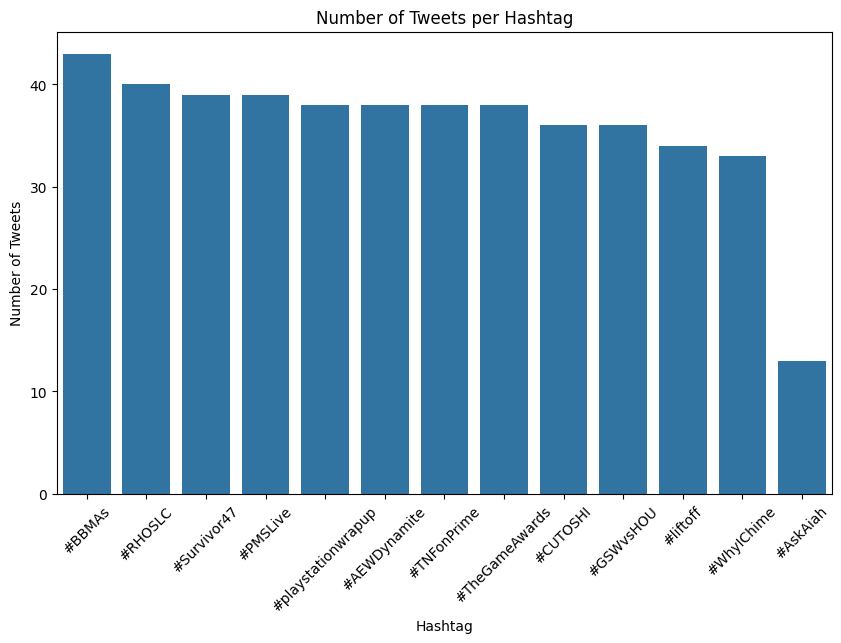

In [18]:
# Plot the distribution of the number of tweets per hashtag
import matplotlib.pyplot as plt
import seaborn as sns

# get the number of tweets per hashtag
tweet_count = data['hashtag'].value_counts()

# plot the count per hashtag
plt.figure(figsize=(10, 6))
sns.barplot(x=tweet_count.index, y=tweet_count.values)
plt.xticks(rotation=45)
plt.xlabel('Hashtag')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Hashtag')
plt.show()

We will now proceed with the preprocessing tasks:


### **Preprocessing Tasks**
1. **Text Cleaning**:
   - Remove unnecessary characters (e.g., URLs, emojis, and special symbols).
   - Convert text to lowercase for consistency.
   - Remove stopwords to focus on meaningful words.
2. **Tokenization**:
   - Split the `text` column into individual words.

3. **Stemming and Lemmatization**:
   - Normalize words to their root form.

Let’s start with **Text Cleaning**.

In [19]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define text cleaning function
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\@w+|\#\w+|\d+|[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Define function for tokenization, stopword removal, and lemmatization, stemming
lemmatizer = WordNetLemmatizer()
stemmer = nltk.PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply text cleaning and preprocessing
data['cleaned_text'] = data['text'].apply(clean_text)
data['processed_text'] = data['cleaned_text'].apply(preprocess_text)

# Display the processed dataset
data[['text', 'cleaned_text', 'processed_text']].head()


[nltk_data] Downloading package punkt to /Users/amandeep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amandeep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amandeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,cleaned_text,processed_text
0,When you've been working 2 jobs all year and s...,when youve been working jobs all year and sta...,youv work job year stay internet still game pe...
1,my #PlayStationWrapUp2024 😎\n\nshare yours in ...,my \n\nshare yours in the comments,share comment
2,#PlayStationWrapUp2024 101 Games this year and...,games this year and nearly k hours\n\nim a r...,game thi year nearli k hour im real gamer
3,I'm shocked! 😏😂\n\n#PlayStationWrapUp2024 http...,im shocked \n\n,im shock
4,My #PlayStationWrapUp2024 has some incorrect n...,my has some incorrect numbers but its right a...,ha incorrect number right one thing play sht h...


# Lets also try TweetTokenizer
we can use TweetTokenizer from NLTK, which is specifically designed to handle social media text. It effectively manages hashtags, mentions, and emoticons. Let's proceed using TweetTokenizer for tokenization, combined with other necessary tools to clean the text, remove stopwords, and perform lemmatization.

Here’s the alternate preprocessing plan:

1. Use TweetTokenizer for tokenization to preserve hashtags and mentions.
2. Remove stopwords using a predefined list.
3. Perform lemmatization using WordNetLemmatizer.
4. Handle text cleaning to remove URLs and special characters.
Let’s implement this updated approach.

In [20]:
from nltk.tokenize import TweetTokenizer

# Initialize TweetTokenizer
tweet_tokenizer = TweetTokenizer()

# Define updated text preprocessing function
def preprocess_tweet(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove special characters and numbers except hashtags and mentions
    text = re.sub(r'[^a-zA-Z0-9@#\s]', '', text)
    # Tokenize using TweetTokenizer
    tokens = tweet_tokenizer.tokenize(text.lower())
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the preprocessing function
data['tweet_tokenizer_processed_text'] = data['text'].apply(preprocess_tweet)

# Display the processed data
data[['text', 'tweet_tokenizer_processed_text', 'processed_text']].head()


,text,tweet_tokenizer_processed_text,processed_text
0,When you've been working 2 jobs all year and s...,youve working 2 job year staying internet stil...,youv work job year stay internet still game pe...
1,my #PlayStationWrapUp2024 😎\n\nshare yours in ...,#playstationwrapup2024 share comment,share comment
2,#PlayStationWrapUp2024 101 Games this year and...,#playstationwrapup2024 101 game year nearly 24...,game thi year nearli k hour im real gamer
3,I'm shocked! 😏😂\n\n#PlayStationWrapUp2024 http...,im shocked #playstationwrapup2024,im shock
4,My #PlayStationWrapUp2024 has some incorrect n...,#playstationwrapup2024 incorrect number right ...,ha incorrect number right one thing play sht h...


But we can't use `TweetTokenizer` as it will preserve the hashtags and that will not be a good option for training our model

In [21]:
data.to_csv('./data/preprocessed_all_tweets.csv', index=False)



4. **Embedding Preparation**:
   - Prepare embeddings using pre-trained models like Word2Vec or BERT for textual analysis.


In [22]:
from gensim.models import Word2Vec

# Tokenize the processed text for Word2Vec (split into list of words for each tweet)
tokenized_texts = data['processed_text'].dropna().apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Generate embeddings for each tweet by averaging the word vectors
def get_tweet_embedding(tweet):
    words = tweet.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if word_vectors:
        return sum(word_vectors) / len(word_vectors)  # Average of word vectors
    else:
        return [0] * 100  # Return zero vector if no valid words

# Ensure all entries in 'data' are strings and handle missing values
data['processed_text'] = data['processed_text'].fillna("").astype(str)

# Apply to generate embeddings
data['word2vec_embedding'] = data['processed_text'].apply(get_tweet_embedding)

# Display the first few rows with embeddings
data[['processed_text', 'word2vec_embedding']].head()


,processed_text,word2vec_embedding
0,youv work job year stay internet still game pe...,"[-0.001370563, 0.0042492347, 0.001108588, 0.00..."
1,share comment,"[0.00019238982, -0.001700449, -0.0019224136, -..."
2,game thi year nearli k hour im real gamer,"[-0.0028708759, 0.0030397119, 0.0029610177, 0...."
3,im shock,"[-0.001030477, 0.0045851488, 0.0061443215, -0...."
4,ha incorrect number right one thing play sht h...,"[-0.00055650354, 0.0031190305, -0.0022407887, ..."


Lets plot the results of word2vec embedding

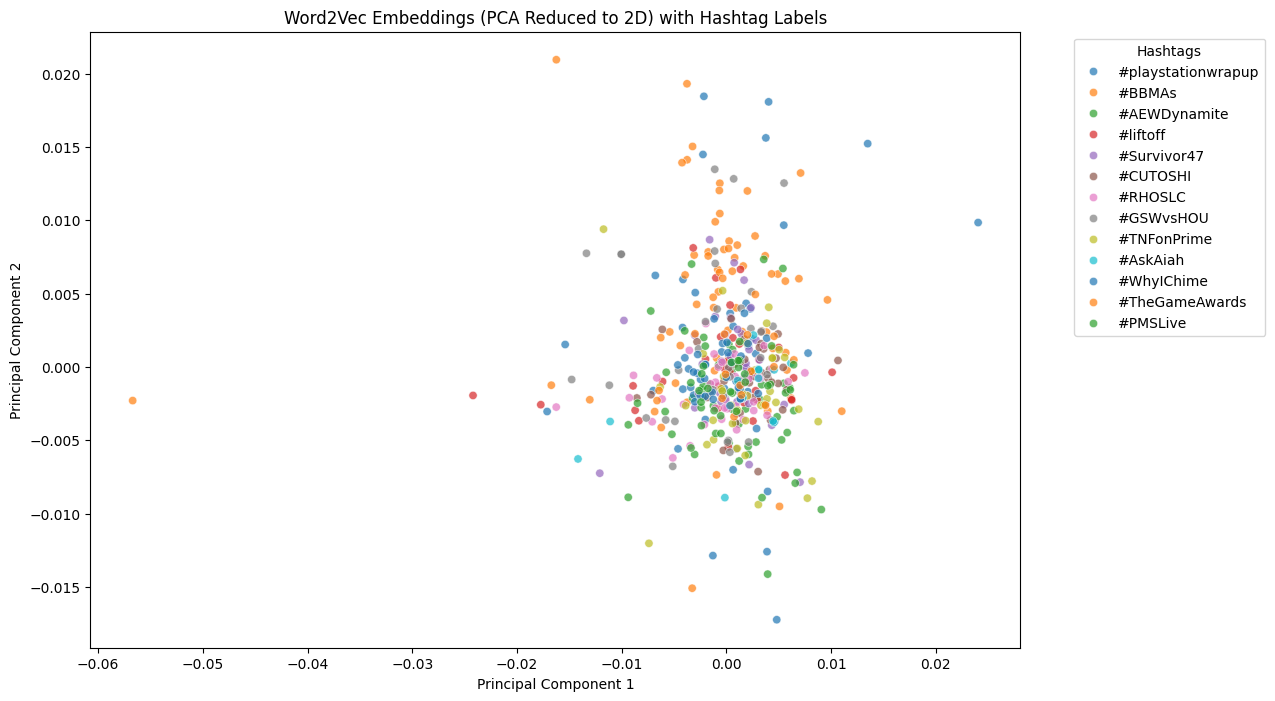

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract embeddings and apply PCA for dimensionality reduction to 2D
embeddings = data['word2vec_embedding'].tolist()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize embeddings with a hue for the primary hashtag
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=data['hashtag'],
    palette='tab10',
    alpha=0.7,
    legend='full'
)
plt.title("Word2Vec Embeddings (PCA Reduced to 2D) with Hashtag Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Hashtags")
plt.show()

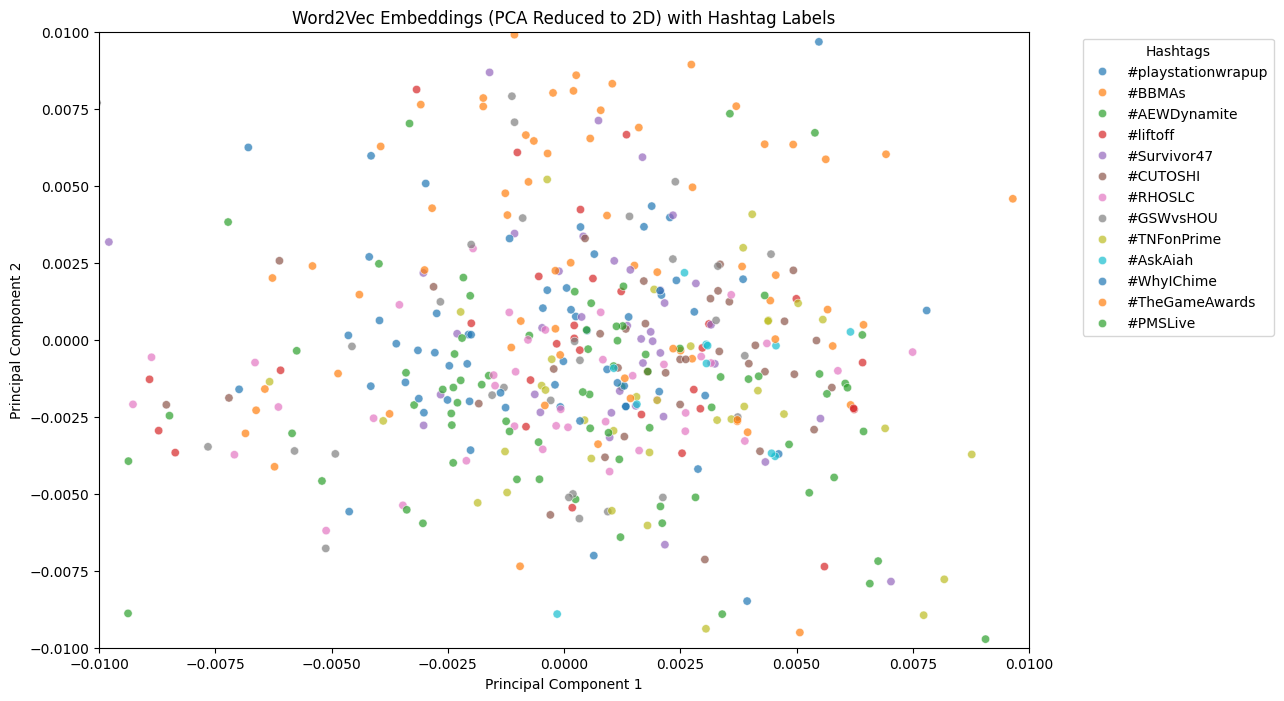

In [24]:
# lets concentrate on the center of the plot

# Visualize embeddings with a hue for the primary hashtag
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=data['hashtag'],
    palette='tab10',
    alpha=0.7,
    legend='full'
)
plt.title("Word2Vec Embeddings (PCA Reduced to 2D) with Hashtag Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Hashtags")
plt.show()

Lets try the BERT embeddings too

In [25]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings for a given text
def generate_bert_embedding(text):
    # Tokenize and encode text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the CLS token embedding as the sentence embedding
    return outputs.last_hidden_state[0][0].numpy()

# Generate BERT embeddings for processed text
data['bert_embedding'] = data['processed_text'].apply(generate_bert_embedding)

# Display the first few rows with BERT embeddings
data[['processed_text', 'bert_embedding']].head()


,processed_text,bert_embedding
0,youv work job year stay internet still game pe...,"[-0.15237881, -0.23478091, -0.0037837625, -0.1..."
1,share comment,"[-0.03560925, -0.03704011, -0.27711895, -0.078..."
2,game thi year nearli k hour im real gamer,"[-0.11251198, 0.0015351195, 0.3717115, 0.03167..."
3,im shock,"[-0.15670533, 0.46346632, 0.0783851, -0.161303..."
4,ha incorrect number right one thing play sht h...,"[-0.8385719, -0.44905365, -0.2720739, 0.089216..."


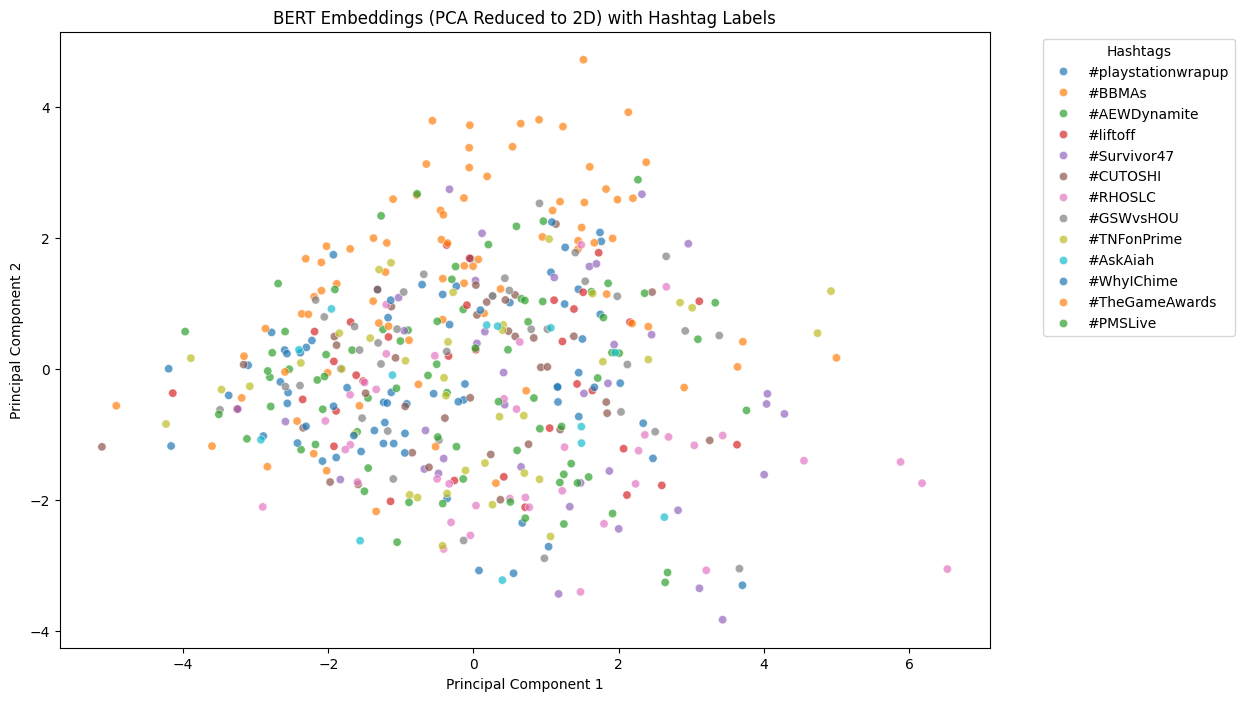

In [26]:
import numpy as np


# Apply PCA to reduce BERT embeddings to 2 dimensions
bert_embeddings = np.vstack(data['bert_embedding'])
pca_bert = PCA(n_components=2)
reduced_bert_embeddings = pca_bert.fit_transform(bert_embeddings)

# Visualize embeddings with a hue for the primary hashtag
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_bert_embeddings[:, 0],
    y=reduced_bert_embeddings[:, 1],
    hue=data['hashtag'],
    palette='tab10',
    alpha=0.7,
    legend='full'
)
plt.title("BERT Embeddings (PCA Reduced to 2D) with Hashtag Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Hashtags")
plt.show()


In [27]:
# dump the data to a csv file
data.to_csv('./data/embedded_all_tweets.csv', index=False)

All the preprocessed data is written into [embedded_all_tweets.csv](./data/embedded_all_tweets.csv) file to be used in the next step of [Data Modelling](./03_DataModelling.ipynb)